In [1]:
pip install openpyxl

/home/zimorodek/anaconda3/envs/daes-env/bin/python: No module named pip
Note: you may need to restart the kernel to use updated packages.


In [5]:
import os
import pandas as pd
import geopandas as gpd
from shapely.geometry import LineString
from tqdm import tqdm

def get_all_files(directory, extension):
    matching_files = []
    for root, _, files in os.walk(directory):
        for file in files:
            if file.lower().endswith(extension.lower()):
                matching_files.append(os.path.join(root, file))
    return matching_files

def process_data(gps_dir, ambulance_dir, output_file='wynik.geojson'):
    # Ładowanie danych karetek
    xls_files = get_all_files(ambulance_dir, '.xlsx')
    if not xls_files:
        raise ValueError("Brak plików .xlsx z wyjazdami!")

    print(f"Wczytywanie {len(xls_files)} plików z danymi karetek...")
    all_ambulance_data = [pd.read_excel(f) for f in xls_files]
    ambulance_df = pd.concat(all_ambulance_data, ignore_index=True)

    ambulance_df['Czas wezwania'] = pd.to_datetime(ambulance_df['Czas wezwania'], errors='coerce')
    ambulance_df['Czas wyjazdu ZRM'] = pd.to_datetime(ambulance_df['Czas wyjazdu ZRM'], errors='coerce')
    ambulance_df['Czas powrotu ZRM'] = pd.to_datetime(ambulance_df['Czas powrotu ZRM'], errors='coerce')

    mask_missing_departure = ambulance_df['Czas wyjazdu ZRM'].isna()
    ambulance_df.loc[mask_missing_departure, 'Czas wyjazdu ZRM'] = ambulance_df.loc[mask_missing_departure, 'Czas wezwania']
    ambulance_df = ambulance_df.dropna(subset=['Czas wyjazdu ZRM', 'Czas powrotu ZRM'])

    ambulance_df = ambulance_df.reset_index(drop=True)
    ambulance_df['wyjazd_id'] = ambulance_df.index.map(lambda i: f"WYZ_{i+1:05}")

    # Ładowanie GPS
    gps_files = get_all_files(gps_dir, '.csv')
    if not gps_files:
        raise ValueError("Brak plików .csv z danymi GPS!")

    print(f"Wczytywanie {len(gps_files)} plików z danymi GPS...")
    gps_data = pd.concat([pd.read_csv(f) for f in gps_files], ignore_index=True)

    gps_data['GPS_TIME'] = pd.to_datetime(gps_data['GPS_TIME'], errors='coerce')
    gps_data = gps_data.dropna(subset=['GPS', 'GPS_TIME', 'GPS_LAT', 'GPS_LON'])
    gps_data['GPS'] = gps_data['GPS'].astype(str)
    gps_data = gps_data.sort_values('GPS_TIME')

    gps_by_id = dict(tuple(gps_data.groupby('GPS')))

    print("Tworzenie LineStringów dla wyjazdów...")

    geo_records = []

    for _, row in tqdm(ambulance_df.iterrows(), total=len(ambulance_df)):
        id_gps = str(row['ID_GPS']).strip().replace(".0", "")
        czas_start = row['Czas wyjazdu ZRM']
        czas_koniec = row['Czas powrotu ZRM']
        wyjazd_id = row['wyjazd_id']
        gps_group = gps_by_id.get(id_gps)

        if gps_group is None:
            continue

        gps_group = gps_group.set_index('GPS_TIME', drop=False)
        match = gps_group.loc[czas_start:czas_koniec]

        points = [
            (lon, lat)
            for _, gps_row in match.iterrows()
            if pd.notnull(gps_row['GPS_LAT']) and pd.notnull(gps_row['GPS_LON'])
            for lat, lon in [(gps_row['GPS_LAT'], gps_row['GPS_LON'])]
        ]

        if len(points) < 2:
            continue  # za mało punktów do utworzenia linii

        geo_records.append({
            'wyjazd_id': wyjazd_id,
            'ID_GPS': id_gps,
            'Czas wyjazdu ZRM': czas_start,
            'Czas powrotu ZRM': czas_koniec,
            'Powód wezwania': row.get('Powód wezwania', ''),
            'Kod pilności': row.get('Kod pilności', ''),
            'Rodzaj wyjazdu': row.get('Rodzaj wyjazdu 0- na sygnale, 1 -zwykly', ''),
            'Typ zespolu': row.get('Typ zespolu', ''),
            'Określenie wieku pacjenta': row.get('Określenie wieku pacjenta 0- dziecko, 1 - dorosly', ''),
            'geometry': LineString(points)
        })

    geo_df = gpd.GeoDataFrame(geo_records, crs="EPSG:4326")

    geo_df.to_file(output_file, driver='GeoJSON')
    print(f"\nZapisano {len(geo_df)} wyjazdów do pliku: {output_file}")


In [6]:
process_data('../gps', '../kzw')

Wczytywanie 1 plików z danymi karetek...
Wczytywanie 7 plików z danymi GPS...


/tmp/ipykernel_19881/1248398595.py:42: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  gps_data = pd.concat([pd.read_csv(f) for f in gps_files], ignore_index=True)


Tworzenie LineStringów dla wyjazdów...


100%|████████████████████████████████████| 63554/63554 [01:25<00:00, 741.40it/s]



Zapisano 576 wyjazdów do pliku: wynik.geojson


In [7]:
import geopandas as gpd

# Wczytaj plik wynikowy
gdf = gpd.read_file("wynik.geojson")  # lub "wynik.gpkg"
gdf.head()


wyjazd_id ID_GPS    Czas wyjazdu ZRM    Czas powrotu ZRM  \
0  WYZ_00191  74302 2022-01-01 05:26:40 2022-01-01 06:55:32   
1  WYZ_00287  74302 2022-01-01 09:08:04 2022-01-01 09:56:08   
2  WYZ_00460  74302 2022-01-01 12:42:30 2022-01-01 14:47:24   
3  WYZ_00617  74302 2022-01-01 15:15:12 2022-01-01 18:44:47   
4  WYZ_00860  74302 2022-01-01 21:13:35 2022-01-01 22:04:44   

            Powód wezwania  Kod pilności  Rodzaj wyjazdu Typ zespolu  \
0  Inne / złe samopoczucie             2               1           P   
1                 Duszność             2               1           P   
2             Zasłabnięcie             2               1           P   
3  Inne / złe samopoczucie             2               1           P   
4                 Duszność             2               0           P   

   Określenie wieku pacjenta  \
0                        1.0   
1                        1.0   
2                        1.0   
3                        1.0   
4                        1.0   

                                            geometry  
0  LINESTRING (20.00079 50.09015, 20.00079 50.090...  
1  LINESTRING (20.01865 50.09204, 20.01865 50.092...  
2  LINESTRING (20.14041 50.19176, 20.14041 50.191...  
3  LINESTRING (20.06996 50.17232, 20.06996 50.172...  
4  LINESTRING (20.00904 50.07685, 20.00904 50.076...

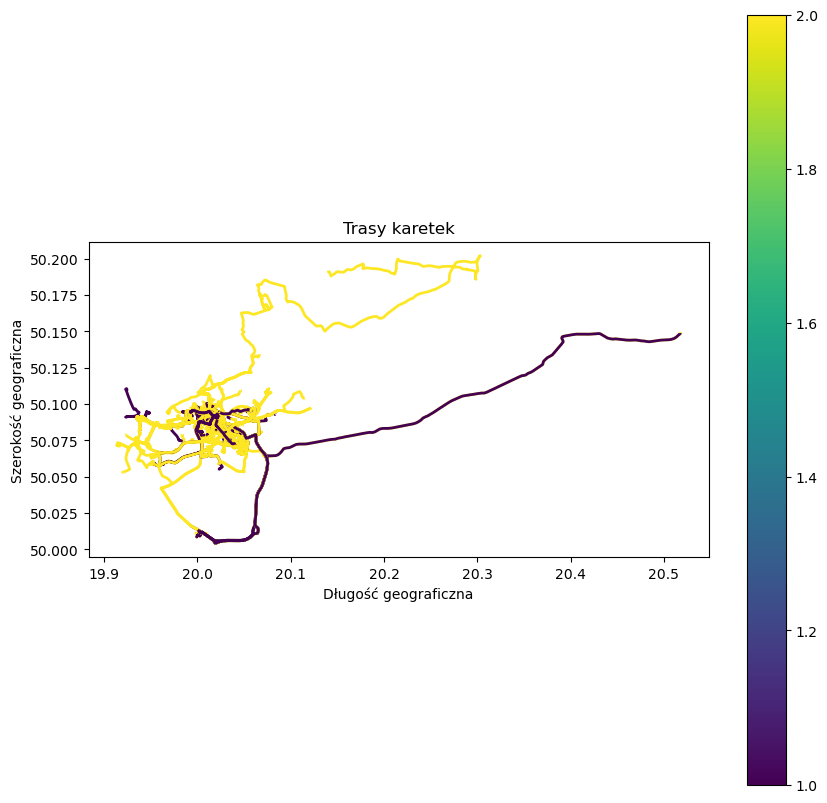

In [8]:
import matplotlib.pyplot as plt

gdf.plot(figsize=(10, 10), linewidth=2, column='Kod pilności', legend=True)
plt.title("Trasy karetek")
plt.xlabel("Długość geograficzna")
plt.ylabel("Szerokość geograficzna")
plt.show()


In [12]:
!pip install geopandas folium matplotlib

Defaulting to user installation because normal site-packages is not writeable
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 20.4 MB/s eta 0:00:000:00:01m eta 0:00:01
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 24.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.1/16.1 MB 24.2 MB/s eta 0:00:00m eta 0:00:010:0101
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.7/12.7 MB 17.8 MB/s eta 0:00:00 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.0/24.0 MB 20.3 MB/s eta 0:00:00 MB/s eta 0:00:0101
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 22.1 MB/s eta 0:00:00m eta 0:00:010:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 23.5 MB/s eta 0:00:00


In [18]:
import geopandas as gpd
import folium
import json

# Wczytaj GeoDataFrame
gdf = gpd.read_file("wynik.geojson")

# Konwertuj datetime na string
for col in gdf.columns:
    if gdf[col].dtype == 'datetime64[ns]':
        gdf[col] = gdf[col].astype(str)

# Zapisz do tymczasowego pliku GeoJSON
gdf.to_file("temp.geojson", driver="GeoJSON")

# Wczytaj jako słownik JSON (gotowy do folium)
with open("temp.geojson", "r", encoding="utf-8") as f:
    geojson_data = json.load(f)

# Środek mapy
center = gdf.geometry.centroid.iloc[0].coords[:][0][::-1]

# Stwórz mapę i dodaj GeoJson
m = folium.Map(location=center, zoom_start=12)
folium.GeoJson(geojson_data).add_to(m)
m


/tmp/ipykernel_19881/2157597527.py:21: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  center = gdf.geometry.centroid.iloc[0].coords[:][0][::-1]
